# Introduction
This notebook looks into the solar energy production data from the renewable energy dataset and does some exploratory data analysis and visualization before forecasting the production using the Prophet Model.

# Data Preparation & Cleaning
We are going to use the Wind & Solar Daily Power Production dataset (https://www.kaggle.com/datasets/henriupton/wind-solar-electricity-production/data) for this model, check for any null values and remove them.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wind-solar-electricity-production/intermittent-renewables-production-france.csv


In [2]:
# Assigning the data to a dataframe
df = pd.read_csv(os.path.join(dirname, filename))
df.head()

,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
0,2020-07-22 20:00:00+02:00,2020-07-22,20:00:00,21:00:00,Solar,244.0,204,Wednesday,July
1,2020-07-23 07:00:00+02:00,2020-07-23,07:00:00,08:00:00,Solar,223.0,205,Thursday,July
2,2020-07-23 16:00:00+02:00,2020-07-23,16:00:00,17:00:00,Solar,2517.0,205,Thursday,July
3,2020-07-23 19:00:00+02:00,2020-07-23,19:00:00,20:00:00,Solar,658.0,205,Thursday,July
4,2020-07-23 23:00:00+02:00,2020-07-23,23:00:00,24:00:00,Solar,0.0,205,Thursday,July


In [3]:
#Separating the data for Solar as source
df_solar = df[df['Source'] == 'Solar']

In [4]:
# Check for null values
df_solar.isnull().sum()

Date and Hour    0
Date             0
StartHour        0
EndHour          0
Source           0
Production       1
dayOfYear        0
dayName          0
monthName        0
dtype: int64

In [5]:
#Remove null values
df_solar=df_solar.dropna()
df_solar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29901 entries, 0 to 59805
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date and Hour  29901 non-null  object 
 1   Date           29901 non-null  object 
 2   StartHour      29901 non-null  object 
 3   EndHour        29901 non-null  object 
 4   Source         29901 non-null  object 
 5   Production     29901 non-null  float64
 6   dayOfYear      29901 non-null  int64  
 7   dayName        29901 non-null  object 
 8   monthName      29901 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 2.3+ MB


In [6]:
#Create another dataframe to have total daily production data (aggregating the hourly data)
df_solar_daily = df_solar.groupby('Date',as_index=False).agg({'Production':'sum'})

In [7]:
#Create one more dataframe to have annual production data (averaging the hourly data by day)
df_solar_annual_avg = df_solar.groupby('dayOfYear',as_index=False).agg({'Production':'mean'})

In [8]:
#Create one more dataframe to have monthly mean production data (averaging the monthly data)
#Sort by Date
df_solar_monthly_avg = df_solar.sort_values(by='Date')
#Group by Month
df_solar_monthly_avg = df_solar_monthly_avg.groupby('monthName',as_index=False,sort=False).agg({'Production':'mean'})
#Data for March is at the bottom of the dataframe, we need to insert that row between February and April.
df_solar_monthly_avg_March = df_solar_monthly_avg[df_solar_monthly_avg['monthName'] == 'March']
df_solar_monthly_avg = df_solar_monthly_avg.drop(index=11)
df_solar_monthly_avg = pd.concat([df_solar_monthly_avg.iloc[:2], df_solar_monthly_avg_March, df_solar_monthly_avg.iloc[2:]])
df_solar_monthly_avg = df_solar_monthly_avg.reset_index(drop=True)                                

In [9]:
#Create another dataframe to have daily mean production data (averaging the hourly data)
df_solar_daily_avg = df_solar.groupby('StartHour',as_index=False).agg({'Production':'mean'})

# Exploratory Data Analysis & Visualization:

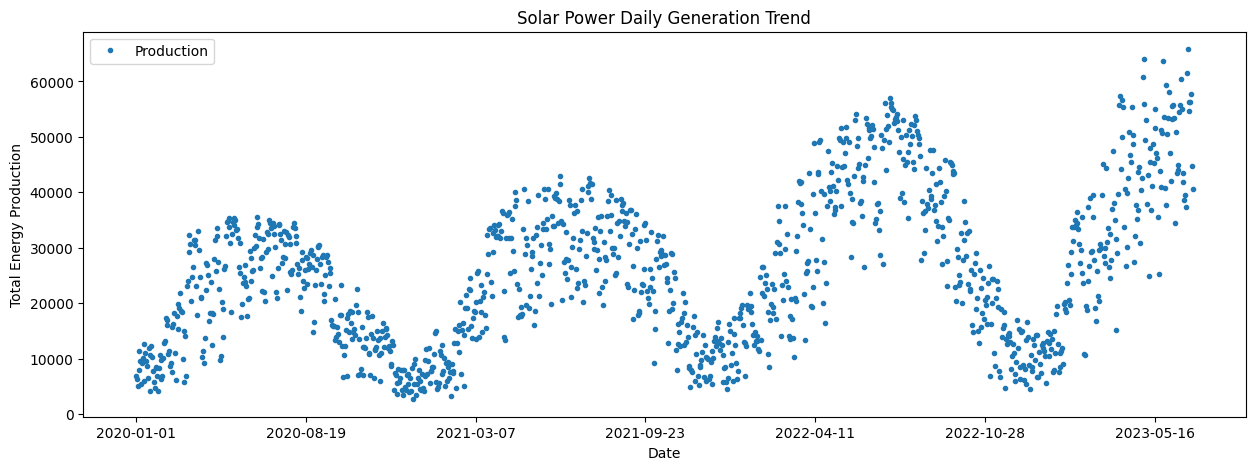

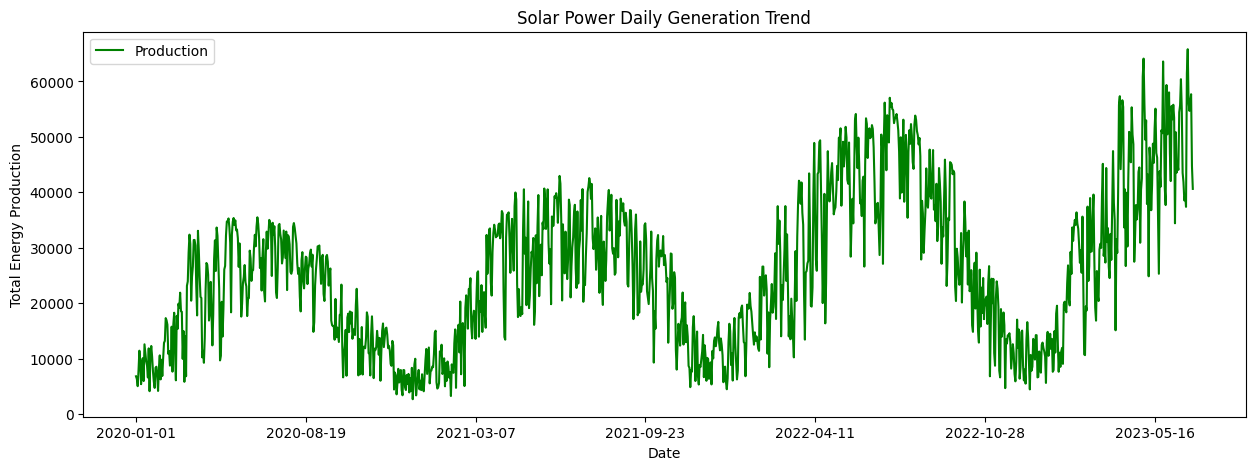

In [10]:
#Plot the daily solar production data
df_solar_daily.plot(x='Date', y='Production', style='.',
          figsize=(15, 5),
          title='Solar Power Daily Generation Trend')
plt.ylabel('Total Energy Production')
plt.show()

df_solar_daily.plot(x='Date', y='Production', kind='line',color = 'g',
          figsize=(15, 5),
          title='Solar Power Daily Generation Trend')
plt.ylabel('Total Energy Production')
plt.show()

We can see that solar production has increased over the years which could be down to more solar installation and increased capacity. We can also see that data is missing for some months (Mar-April) in 2020. Let's investigate the months for which the data is missing.

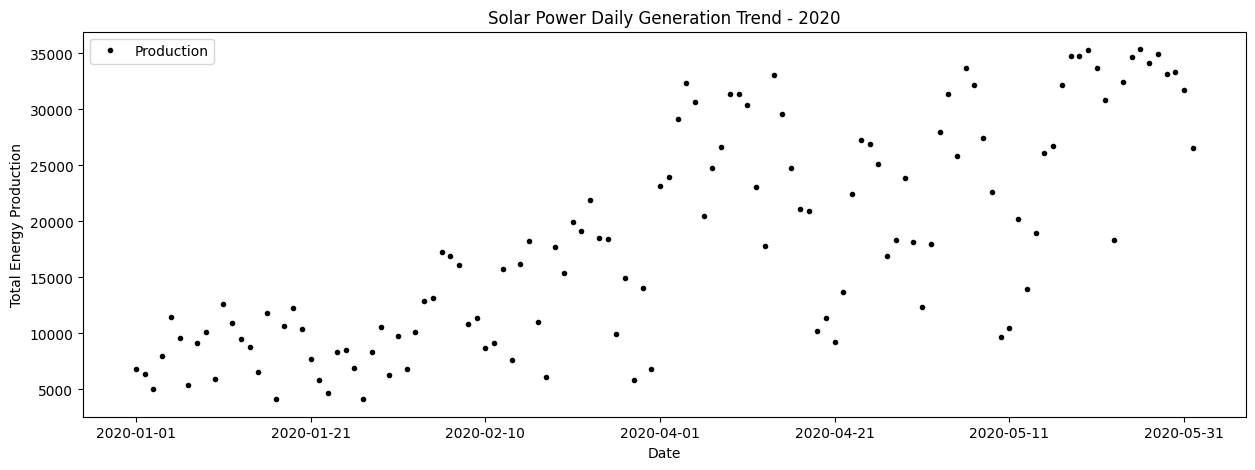

In [11]:
#Create a subsetted dataframe for the first five months of 2020
df_solar_2020 = df_solar[df_solar['Date'] <= '2020-06-01']
df_solar_2020 = df_solar_2020.groupby('Date',as_index=False).agg({'Production':'sum'})
#Plot the daily solar production data
df_solar_2020.plot(x='Date', y='Production', style='.',color='k',
          figsize=(15, 5),
          title='Solar Power Daily Generation Trend - 2020')
plt.ylabel('Total Energy Production')
plt.show()

We can see that we are missing the data for the month of March, 2020. Ideally, with some data from the past year we could've predicted/backfilled this data but let's ignore the data for now. Now, let's see the seasonal decomposition of the data.

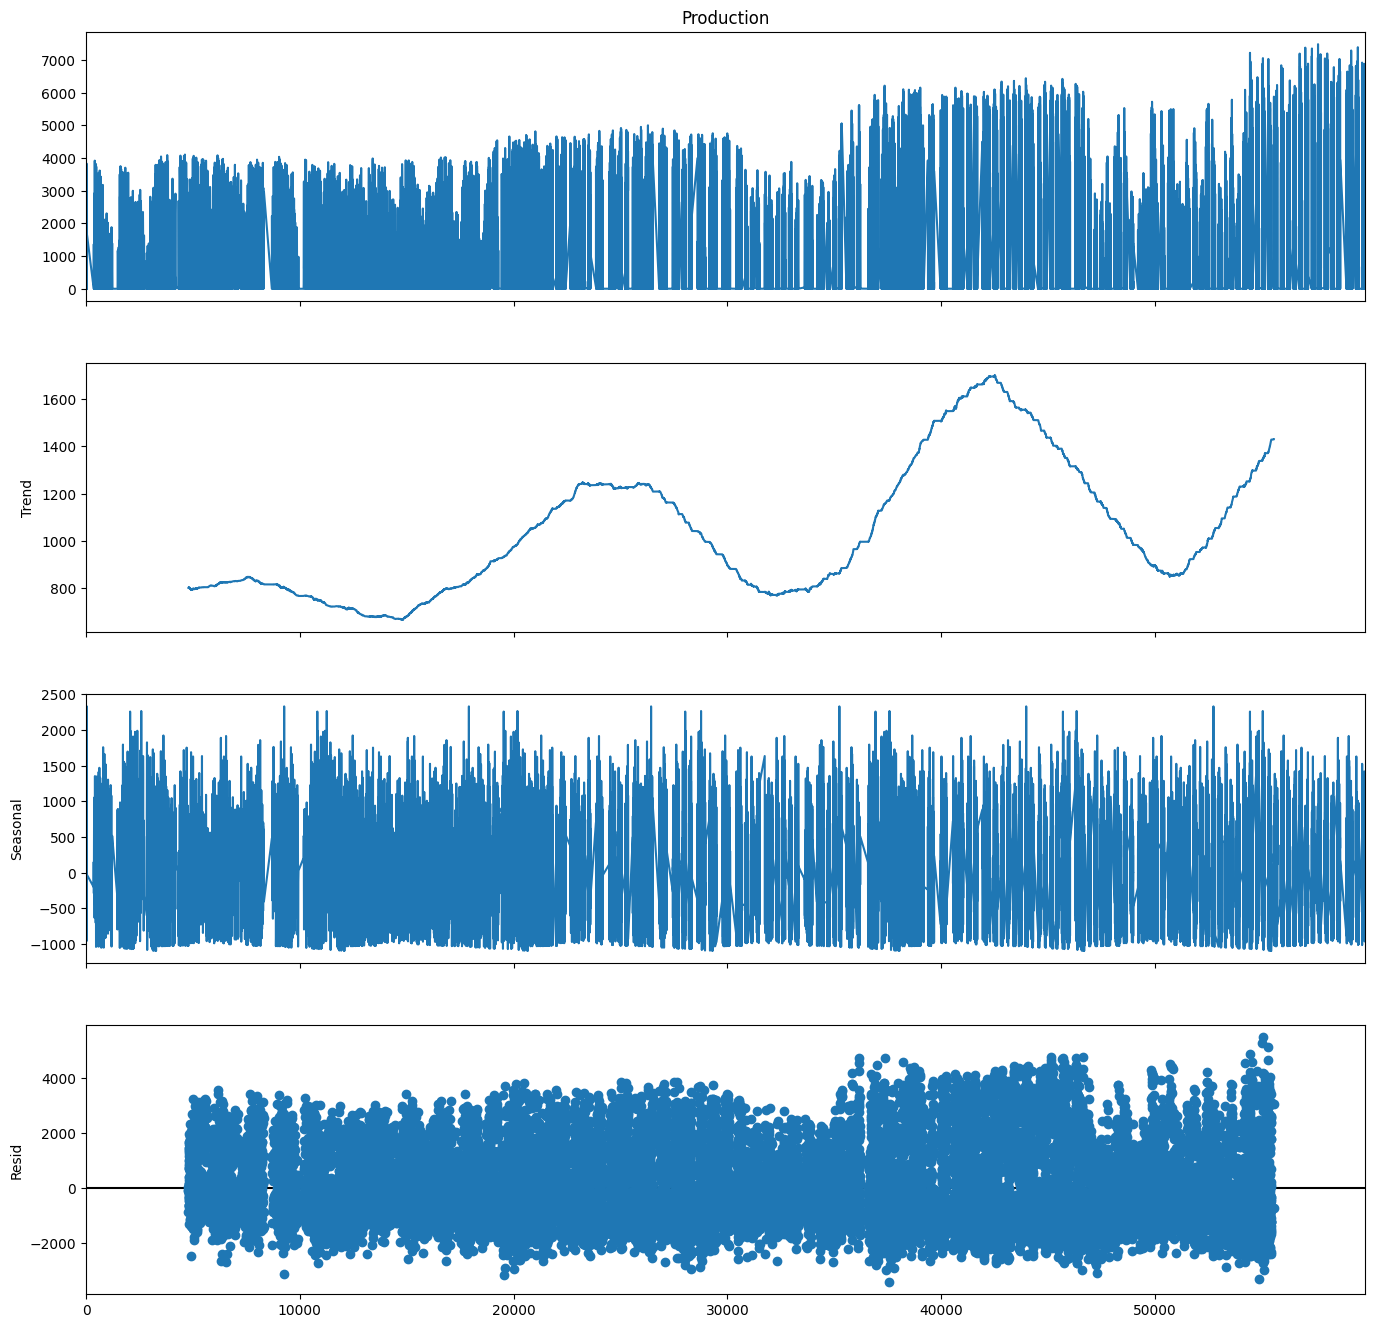

In [22]:
# Decompose the time series - hourly
decomposition = sm.tsa.seasonal_decompose(df_solar['Production'], period=365*12)
fig = decomposition.plot()
fig.set_size_inches(15, 15)
plt.show()

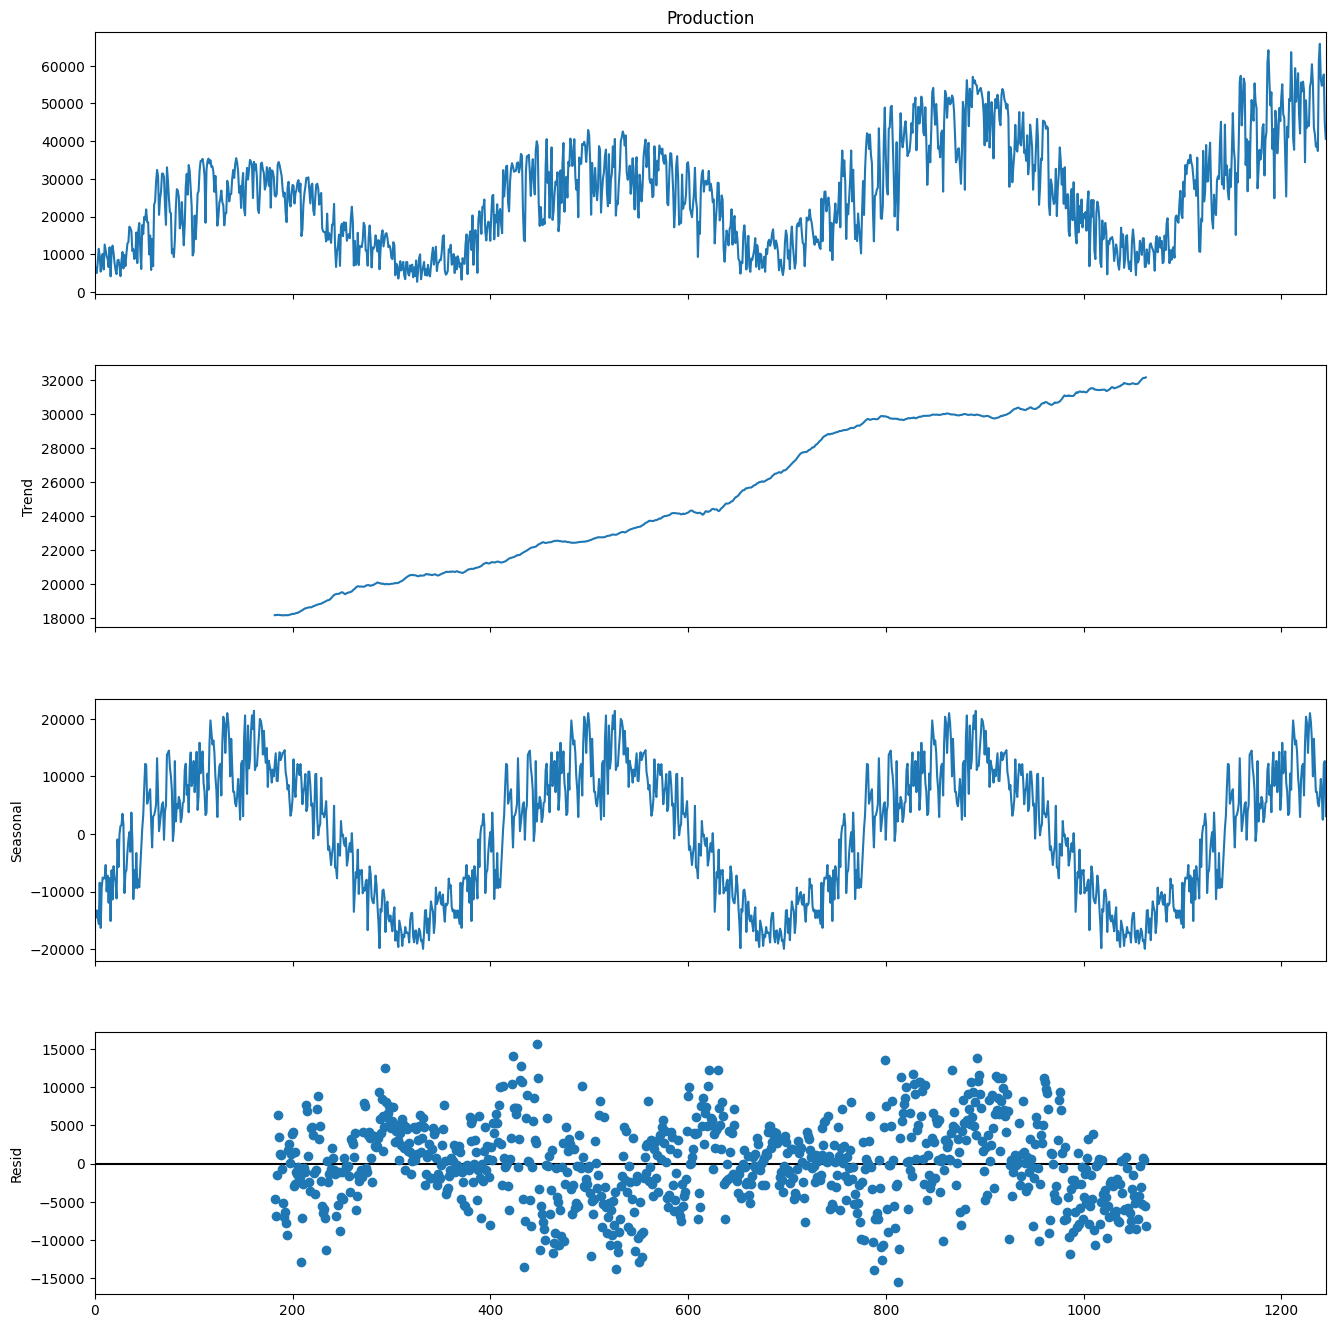

In [13]:
# Decompose the time series - daily
decomposition = sm.tsa.seasonal_decompose(df_solar_daily['Production'], period=365)
fig = decomposition.plot()
fig.set_size_inches(15, 15)
plt.show()

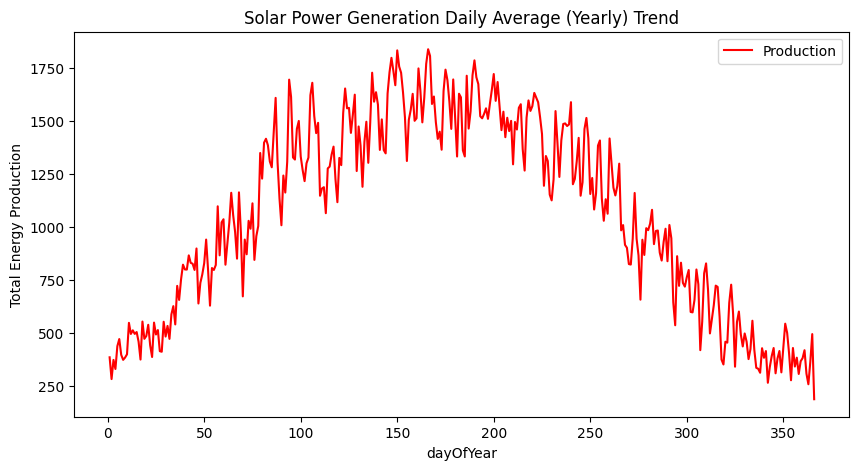

In [14]:
#Plot the monthly average production
df_solar_annual_avg.plot(x='dayOfYear', y='Production', kind='line',color = 'r',                      
          figsize=(10, 5),
          title='Solar Power Generation Daily Average (Yearly) Trend')
plt.ylabel('Total Energy Production')
plt.show()

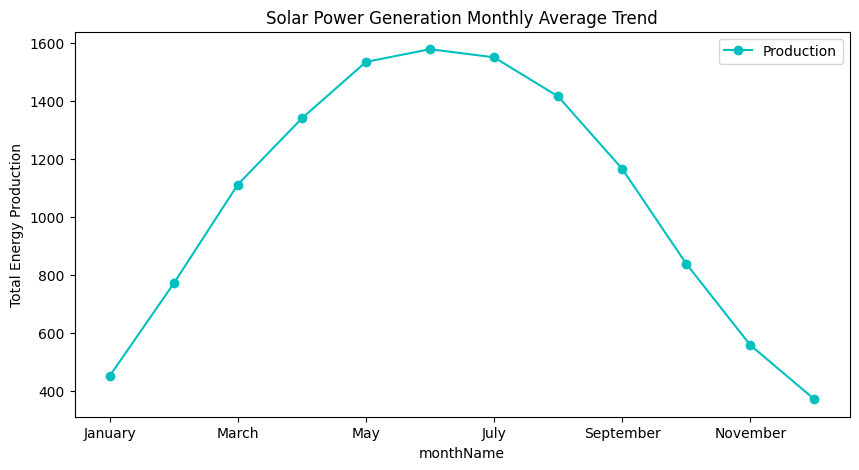

In [15]:
#Plot the monthly average production
df_solar_monthly_avg.plot(x='monthName', y='Production', kind='line',color = 'c', 
          marker='o',                
          figsize=(10, 5),
          title='Solar Power Generation Monthly Average Trend')
plt.ylabel('Total Energy Production')
plt.show()

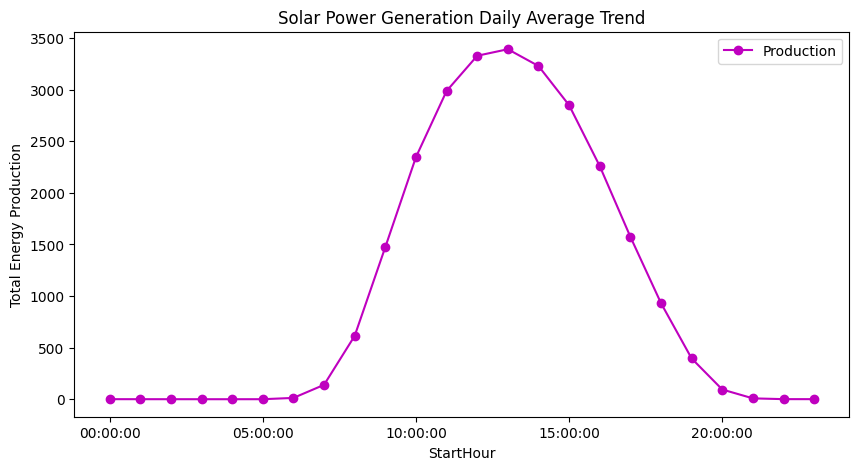

In [16]:
#Plot the daily average production
df_solar_daily_avg.plot(x='StartHour', y='Production', kind='line',color = 'm',
          marker='o',              
          figsize=(10, 5),
          title='Solar Power Generation Daily Average Trend')
plt.ylabel('Total Energy Production')
plt.show()

# Forecasting
Using the prophet model from Facebook we'll forecast the data for solar daily production in future

In [17]:
# Format data for prophet model using ds and y
df_solar_daily['Date'] = pd.to_datetime(df_solar_daily['Date'])
df_prophet = df_solar_daily.rename(columns={'Date':'ds','Production':'y'})

In [18]:
# Import the model and 
from prophet import Prophet
m = Prophet()
m.fit(df_prophet)
# Create future dataframe
future= m.make_future_dataframe(periods=365)
forecast= m.predict(future)

07:23:32 - cmdstanpy - INFO - Chain [1] start processing
07:23:32 - cmdstanpy - INFO - Chain [1] done processing


/opt/conda/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


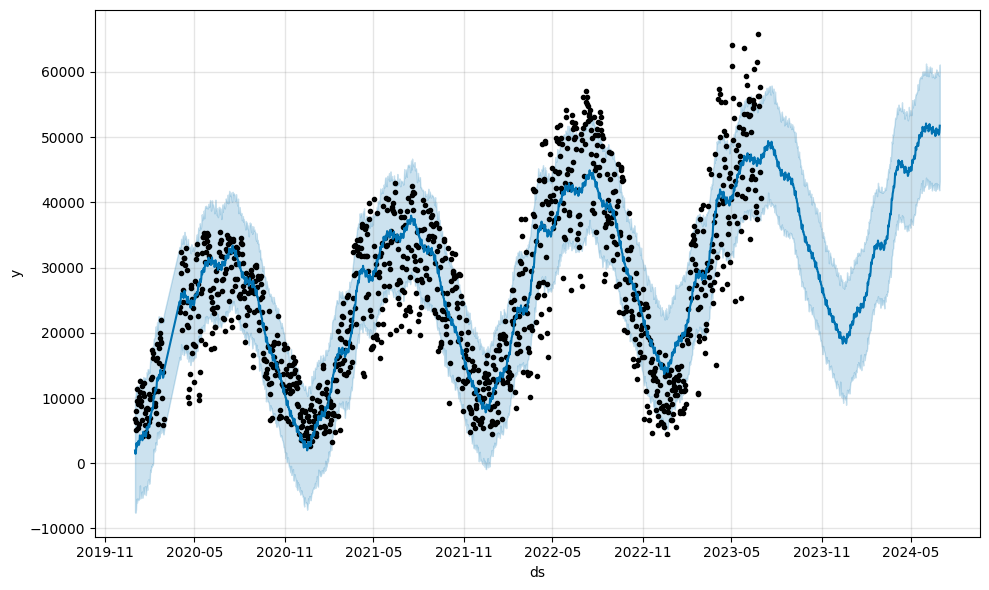

In [19]:
#Plot the forecast
fig1 = m.plot(forecast)
plt.show()

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:349: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:352: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

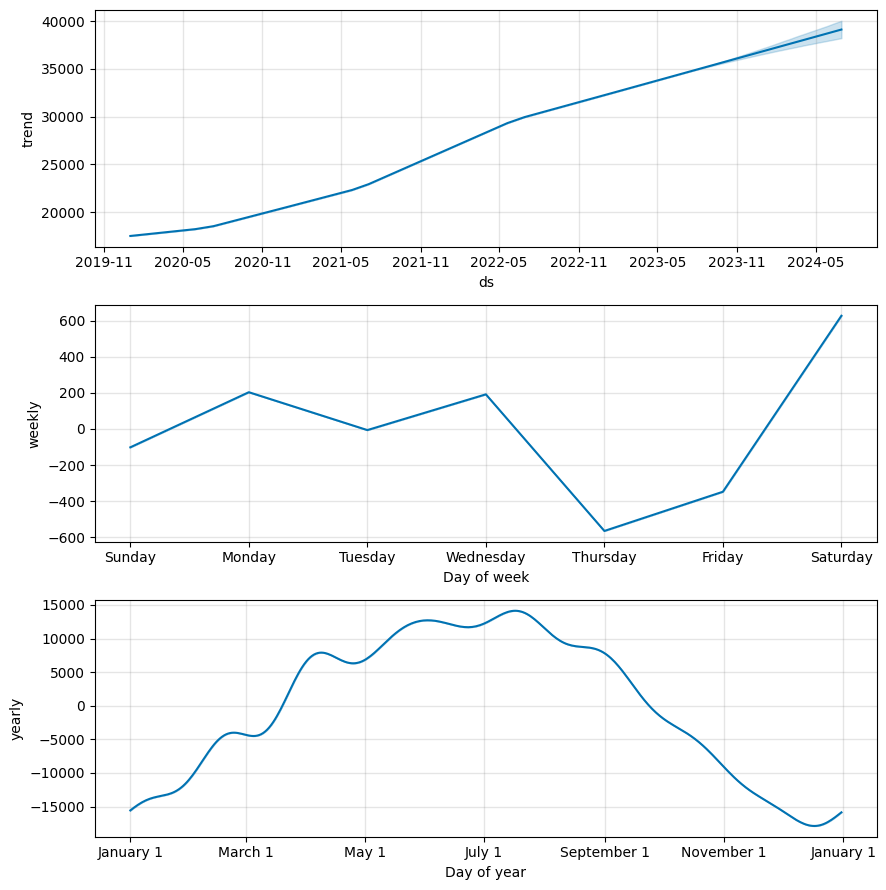

In [20]:
fig2 = m.plot_components(forecast)
plt.show()